### GPyTorch reprex

This notebook makes a minimal reproducible example for running a GP model on elevation data. We do this in the following steps:

 - `torch.DataLoader` to pull a chunk from the zarr dataset
 - Transformation function to turn the chunk into a `torch.Tensor`
 - Feed the `Tensor` into a GPyTorch model

### DataLoader

Adapted from [here](https://discuss.pytorch.org/t/dataloader-parallelization-synchronization-with-zarr-xarray-dask/176149).

In [1]:
%pip install torch tqdm gpytorch

  Obtaining dependency information for gpytorch from https://files.pythonhosted.org/packages/12/24/805d9a4fcb5d105b95b2dac56d0764cfcceba31319437ca94a6592552f84/gpytorch-1.11-py3-none-any.whl.metadata
  Obtaining dependency information for linear-operator>=0.5.0 from https://files.pythonhosted.org/packages/4e/3b/c86ec0c226763a2a199b370f50309ef58c0d8c1555e6a278bd053263881f/linear_operator-0.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for jaxtyping>=0.2.9 from https://files.pythonhosted.org/packages/1f/8f/90f81553044a40c56e546b24de94cafd0a7549ee0361ec39882c5e2abb15/jaxtyping-0.2.23-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 4.2 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [43]:
import numpy as np
import gpytorch
import xarray as xr
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import math
import matplotlib.pyplot as plt

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44437")
client

In [3]:
# Open the dataset
baker_url = 's3://petrichor/geosmart/baker.zarr/'
baker_ds = xr.open_dataset(
    baker_url, chunks='auto', engine='zarr', storage_options={"anon": True}
)

In [4]:
baker_ds

<xarray.Dataset>
Dimensions:      (time: 55, y: 12089, x: 11383)
Coordinates:
  * time         (time) datetime64[ns] 1947-09-14 1950-09-02 ... 2020-12-12
  * x            (x) float64 5.809e+05 5.809e+05 ... 5.923e+05 5.923e+05
  * y            (y) float64 5.409e+06 5.409e+06 ... 5.397e+06 5.397e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 712, 670), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

In [5]:
import xarray as xr
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class XarrayRayChunkedDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.chunk_coords = self._get_chunk_coordinates(data)
        
    def _get_chunk_coordinates(self, data):
        coords = []
        chunk_info = dict(data.chunks)
        for i in range(len(chunk_info["x"])):
            for j in range(len(chunk_info["y"])):
                for k in range(len(chunk_info["time"])):
                    x_start = sum(chunk_info["x"][:i])
                    x_chunk = chunk_info["x"][i]
                    
                    y_start = sum(chunk_info["y"][:j])
                    y_chunk = chunk_info["y"][j]
                    
                    t_start = sum(chunk_info["time"][:k])
                    t_chunk = chunk_info["time"][k]
                    
                    coords.append({'x': slice(x_start, x_start + x_chunk), 
                                   'y': slice(y_start, y_start + y_chunk), 
                                   'time': slice(t_start, t_start + t_chunk)})
        return coords
    
    def __len__(self):
        return len(self.chunk_coords)
    
    def __getitem__(self, idx):
        # TODO convert to a torch.Tensor of shape (N, 4)
        return self.data.isel(self.chunk_coords[idx])
    
dataset = XarrayRayChunkedDataset(baker_ds)
chunk = dataset[0]

### Transform chunk to a tensor

In [6]:
df = chunk.band1.to_dataframe().dropna().reset_index()
df.head()

,time,y,x,band1
0,1947-09-14,5.409449e+06,580947.438712,706.601624
1,1947-09-14,5.409449e+06,580948.438712,707.278198
2,1947-09-14,5.409449e+06,580949.438712,707.780396
3,1947-09-14,5.409449e+06,580950.438712,708.258789
4,1947-09-14,5.409449e+06,580951.438712,708.737122


In [7]:
# Cast times to a number
df['time'] = (df['time'] - df['time'].min())  / np.timedelta64(1,'D')

In [35]:
# Make the X and Y tensors
df_numpy = df.to_numpy(dtype=np.float64)
df_numpy.shape

X = torch.from_numpy(df_numpy[:,:-1]).float()
Y = torch.from_numpy(df_numpy[:,-1]).float()

print(X.shape, Y.shape)

torch.Size([16100086, 3]) torch.Size([16100086])


### Train model with the tensor

Copied from [here](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html)

In [51]:
# Allocates too much memory with full chunk, try again with a smaller size
X_small = X[:10000, :]
Y_small = Y[:10000]

X_test = X[10001:20000, :]
Y_test = Y[10001:20000]


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_small.cuda(), Y_small.cuda(), likelihood)

In [52]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [53]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model.cuda())

training_iter = 50

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_small.cuda())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_small.cuda())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 125101.961   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 104563.047   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 88063.758   lengthscale: 0.798   noise: 0.797
Iter 4/50 - Loss: 74538.461   lengthscale: 0.853   noise: 0.851
Iter 5/50 - Loss: 63386.078   lengthscale: 0.909   noise: 0.904
Iter 6/50 - Loss: 54497.855   lengthscale: 0.966   noise: 0.957
Iter 7/50 - Loss: 46691.141   lengthscale: 1.023   noise: 1.009
Iter 8/50 - Loss: 40363.102   lengthscale: 1.081   noise: 1.059
Iter 9/50 - Loss: 35432.340   lengthscale: 1.139   noise: 1.108
Iter 10/50 - Loss: 31126.408   lengthscale: 1.195   noise: 1.154
Iter 11/50 - Loss: 27553.510   lengthscale: 1.251   noise: 1.199
Iter 12/50 - Loss: 24659.582   lengthscale: 1.306   noise: 1.241
Iter 13/50 - Loss: 22209.357   lengthscale: 1.359   noise: 1.281
Iter 14/50 - Loss: 20000.303   lengthscale: 1.412   noise: 1.319
Iter 15/50 - Loss: 18308.002   lengthscale: 1.462   noise: 1.355
Iter 16/50 - Loss: 16752.570   l

In [90]:
# Below does not work because of a type mismatch - not sure why :(

# Visualize output

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test.cuda()))

In [91]:
observed_pred.mean.cpu()

tensor([699.9885, 679.6787, 658.1597,  ...,   2.4762,   2.4762,   2.4762])

Text(0, 0.5, 'Predicted elevation [m]')

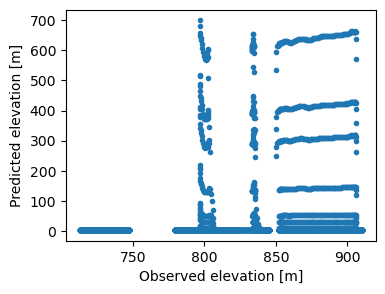

In [94]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(Y_test.numpy(),observed_pred.mean.cpu().numpy(),linestyle='None',marker='.')
#ax.plot([650,1000],[650,1000])
#ax.set_xlim([650,1000])
#ax.set_ylim([500,1000])
ax.set_xlabel('Observed elevation [m]')
ax.set_ylabel('Predicted elevation [m]')

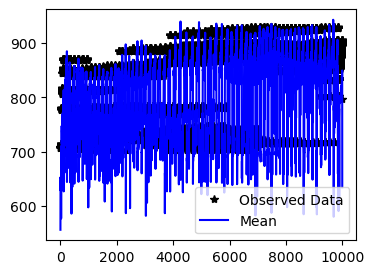

In [75]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot( Y_small.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [63]:
X_small.shape

torch.Size([10000, 3])